<a href="https://colab.research.google.com/github/daviddralle/salmonid_and_subsurface/blob/main/temp_salmonid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages and imports

In [ ]:
import requests
def download_file(url,fn):
  # fn = url.split('/')[-1]
  r = requests.get(url, allow_redirects=True)
  open(fn, 'wb').write(r.content)

download_file('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/peakdetect.py','peakdetect.py')
download_file('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/lith.csv','lith.csv')
download_file('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/teaching_data/dry_discharge.csv','dry_discharge.csv')
download_file('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/teaching_data/elder_discharge.csv','elder_discharge.csv')
download_file('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/level4e.csv','level4e.csv')

!pip install -q geopandas

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from peakdetect import peakdet as peakdet
from scipy.optimize import curve_fit
import geopandas as gp
import glob
import matplotlib
import scipy.optimize as optimization
#from mpl_toolkits.basemap import Basemap

# import geopandas as gpd
import pickle
import urllib3
import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# Download data and format

In [ ]:
data = pd.read_csv('./level4e.csv', parse_dates=True, index_col=0)

data = data[['DRY (temp (degC))','MS-FLUME (temp (degC))','MSP1 (temp (degC))','HANK (temp (degC))']]
dry_temp = data.loc['09-2018':'07-2019']
air = pd.read_csv('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/airtemp.csv',index_col=0,parse_dates=True)
url = 'https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_00010=on&cb_00060=on&format=rdb&site_no=11475560&period=&begin_date=2018-03-01&end_date=2021-03-15'
elder_temp = pd.read_csv(url,header=30,sep='\t')
elder_temp['datetime'] = pd.to_datetime(elder_temp['20d'])
elder_temp['elder temp (C)'] = elder_temp['14n']
elder_temp = elder_temp[['datetime','elder temp (C)']].set_index('datetime')

url = 'http://jessehahm.github.io/data/Fox_Water_0.csv'
fox = pd.read_csv(url,header=1,index_col=1,parse_dates=True).resample('D').mean()['Temp, °C (LGR S/N: 2033056, SEN S/N: 2033056)']
url = 'http://jessehahm.github.io/data/Fox_ATM.csv'
fox_air = pd.read_csv(url,header=1,index_col=1,parse_dates=True).resample('D').mean()['Temp, °C (LGR S/N: 2026090, SEN S/N: 2026090)']
fox = pd.concat([fox, fox_air],axis=1)
fox.columns = ['fox', 'fox_air']



# Plot temperature 

Dry Creek slope: 0.66
Elder Creek slope: 0.37


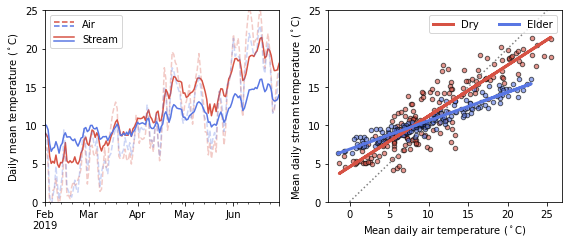

In [ ]:
cmap = matplotlib.cm.get_cmap('coolwarm')
celder = cmap(0.1)
cdry = cmap(0.9)

elder_temp = elder_temp.resample('1H').mean()
dry_temp = dry_temp.resample('1H').mean()
air = air.resample('1H').mean()
temperature = pd.concat([elder_temp, dry_temp, air],join='inner',axis=1)
temperature.columns = ['elder', 'dry', 'flume', 'msp1', 'hank','dry_air', 'elder_air']

f,axs = plt.subplots(1,2,figsize=(8,3.5))
ax = axs[0]
temp = temperature.loc['2019-02':'2019-06']
temp['dry'].resample('D').mean().plot(ax=ax,c=cdry,label='Dry - Stream')
temp['dry_air'].resample('D').mean().plot(ax=ax,c=cdry,ls='--',alpha=0.3,label='Dry - Air')
temp['elder'].resample('D').mean().plot(ax=ax,c=celder,label='Elder - Stream')
temp['elder_air'].resample('D').mean().plot(ax=ax,c=celder,ls='--',alpha=0.3,label='Elder - Air')
ax.set_ylabel(r'Daily mean temperature ($^\circ$C)')
ax.set_ylim([0,25])

from matplotlib.legend_handler import HandlerBase
class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0,y0+width], [0.8*height,0.8*height],
                          linestyle=orig_handle[0], color=orig_handle[1])
        l2 = plt.Line2D([x0,y0+width], [0.2*height,0.2*height], 
                          color=orig_handle[2],linestyle=orig_handle[0])
        return [l1, l2]

ax.legend([('--',cdry,celder),('-',cdry,celder)], [r'Air',r'Stream'],
           handler_map={tuple: AnyObjectHandler()})

# ax.legend()

ax = axs[1]
temp = temperature.loc['2019-01':'2019-06']
m,b = np.polyfit(temp['dry_air'].resample('D').mean(), temp['dry'].resample('D').mean(),deg=1)
print('Dry Creek slope: %.2f'%m)
ax.plot(temp['dry_air'].resample('D').mean(), temp['dry_air'].resample('D').mean()*m+b,c=cdry,zorder=10,lw=3,label='Dry')
m,b = np.polyfit(temp['elder_air'].resample('D').mean(), temp['elder'].resample('D').mean(),deg=1)
print('Elder Creek slope: %.2f'%m)
ax.plot(temp['elder_air'].resample('D').mean(), temp['elder_air'].resample('D').mean()*m+b,c=celder,zorder=10,lw=3,label='Elder')
ax.plot([0,25],[0,25],ls=':',c='gray')
ax.set_xlabel(r'Mean daily air temperature ($^\circ$C)')
ax.set_ylim([0,25])
ax.set_ylabel(r'Mean daily stream temperature ($^\circ$C)')
ax.legend(ncol=2,loc='upper right')
ax.scatter(temp['dry_air'].resample('D').mean(), temp['dry'].resample('D').mean(),color=cdry,s=20,ec='k',alpha=0.6)
ax.scatter(temp['elder_air'].resample('D').mean(), temp['elder'].resample('D').mean(),color=celder,s=20,ec='k',alpha=0.6)

f.tight_layout()
f.savefig('./temperature.pdf')